# Estratégias de Treino

Neste script vamos conhecer as principais estratégias de treino e utilização de redes neurais convolucionais:
* Treino do zero (*from scratch*)
* **Extração de Características**
* ***Fine-Tuning* (ajuste fino)**

Mas antes de tudo, vamos fazer os imports.

In [16]:
# Implementação e treinamento da rede
import torch
from torch import nn, optim

# Carregamento de Dados e Modelos
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision import transforms

# Plots e análises
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time, os

%matplotlib inline

# Configurando hiperparâmetros.
args = {
    'epoch_num': 5,      # Número de épocas.
    'lr': 1e-3,           # Taxa de aprendizado.
    'weight_decay': 8e-4, # Penalidade L2 (Regularização).
    'batch_size': 20,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Extração de características

Esta estratégia tem como base o uso de modelos **pré-treinados** em datasets de larga escala. Redes treinadas em uma quantidade significativa e bem diversa de dados são capazes de extrair características de altíssima qualidade em dados que nunca viram antes.

Como apresentado na imagem, a extração é realizada da seguinte forma:
* **Adapta-se a rede**: A camada de classificação é removida da rede pré-treinada. 
* **Extrai as características**: Realiza o forward dos dados na rede. A última camada agora não realiza classificação, apenas produz características de alto nível semântico.
* **Treina um classificador comum**: Alimenta as características extraídas dos dados de treino e de teste a um classificador (como o SVM).

<img src="https://drive.google.com/uc?export=view&id=1Pulm0YqT53yB34eCkQSbCbzHuBPtAhU9" alt="drawing" width="650"/>

## Carregando Dados

Nesse script usaremos um modelo pré-treinado no **[ImageNet](http://www.image-net.org/)**, um dataset com 1.000 classes de objeto. Até os dias de hoje, modelos pré-treinados nesse conjunto de dados produzem características que servem como base para inúmeras aplicações.

O carregamento de dados deve seguir **o mesmo pré-processamento** do treinamento do modelo utilizado. <br>
Pré-processamento com base no ImageNet: https://github.com/pytorch/examples/blob/master/imagenet/main.py#L202

Usaremos uma **[composição de transformações](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose)** do PyTorch para realizar múltiplas transformações no dado.

```python
transforms.Compose([
     # Lista de transformações.
])
```

In [17]:
data_transform = transforms.Compose([
                                     transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                  ])

train_set = datasets.CIFAR10('.', 
                      train=True, 
                      transform= data_transform, # transformação composta 
                      download=True)

test_set = datasets.CIFAR10('.', 
                      train=False, 
                      transform= data_transform, # transformação composta 
                      download=False)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

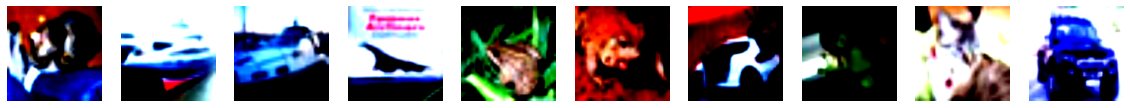

In [18]:
fig, axs = plt.subplots(1,10, figsize=(20, 2))
for i in range(10):
  data, label = test_set[i]
  axs[i].imshow(data.permute((1,2,0)))
  axs[i].axis('off')

In [19]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

## Adaptando a rede

Vamos escolher um modelo da biblioteca de modelos pré-treinados do PyTorch:<br>
https://pytorch.org/docs/stable/torchvision/models.html

Infelizmente o PyTorch não inclui um modelo pré-treinado da LeNet que implementamos anteriormente. Usaremos então um dos modelos modernos de CNN.

In [21]:
net = models.vgg16_bn(pretrained=True).to(args['device'])
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Através da função ```net.children()``` conseguimos acessar individualmente os módulos implementados na rede. 

https://pytorch.org/docs/stable/nn.html#torch.nn.Module.children

In [ ]:
print(list(net.named_children())[-1])

Podemos redefinir a rede com todos os módulos originais **exceto o último**, responsável pela classificação das características aprendidas pelas camadas anteriores.

In [ ]:
net.classifier = nn.Sequential(list(net.children())[-1][:-3]).to(args['device'])
print(net)

## Extraindo

Nesse passo realizamos o mesmo fluxo da função de validação que implementamos anteriormente. Dessa vez não precisamos calcular a predição final, apenas armazenar as saídas da rede.

In [ ]:
def extrai_caracteristicas(net, loader):

  # Evaluation mode
  net.eval()

  feat_list, rotulo_list = [], []
  with torch.no_grad(): 
    for k, batch in enumerate(loader):
      print('\r--{0}/{1}--'.format(k, len(loader)), end='', flush=True)

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Extração
      caracteristica = net(dado)
      feat_list.append(caracteristica.detach().cpu().numpy())
      rotulo_list.append(rotulo.detach().cpu().numpy())

  feat_list    = np.asarray(feat_list)
  feat_list    = np.reshape(feat_list, (feat_list.shape[0]*feat_list.shape[1], feat_list.shape[2]))

  rotulo_list  = np.asarray(rotulo_list).ravel()
 
  return feat_list, rotulo_list
    

In [ ]:
print('Load train')
train_X, train_Y = extrai_caracteristicas(net, train_loader)
print('\nLoad test')
test_X,  test_Y  = extrai_caracteristicas(net, test_loader)

### Treinando um modelo de classificação (SVM)
Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

Modelos de classificação no pacote ```scikit-learn``` seguem o seguinte padrão de uso:
```python
# Definição do classificador
clf = LinearSVC()
#Treinando 
clf.fit(X, y)
# Usando no teste
pred = clf.predict(Xt)
```

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(train_X, train_Y)

pred = clf.predict(test_X)
print('{:.2f}%'.format(accuracy_score(test_Y, pred)*100))



---


# Fine-Tuning

O objetivo aqui é aproveitar o valor de um modelo bem treinado e sua capacidade de generalizar pra dados que nunca viu antes.
 
Lembre-se que o aprendizado é hierárquico, ou seja, camadas iniciais (em vermelho na imagem) aprendem características de baixo nível (bordas, quinas, etc.) que podem ser aproveitadas para múltiplos datasets. **Adaptamos então camadas mais semânticas** (em amarelo na imagem), que aprendem características mais específicas do dataset de treino. 

Aqui seguiremos dois passos:
* Substituir a camada de classificação da rede original;
* "Congelar" camadas iniciais da rede, para preservar seus pesos;
* Definir múltiplas taxas de aprendizado para treinar as camadas finais.

<img src="https://drive.google.com/uc?export=view&id=1BHzTprOsXunB7xmKZ7amcScfh2MRSqO1" alt="drawing" width="400"/>

## Adaptando a Rede

In [22]:
net = models.vgg16_bn(pretrained=True).to(args['device'])
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Dessa vez vamos redefinir a camada de classificação, criando uma nova camada de dimensões adequadas ao nosso desafio.

* O modelo original classificava as 1.000 classes do ImageNet <br>
```nn.Linear(in_features, 1000)```
* Nossa adaptação irá classificar 10 classes do CIFAR10 <br> 
```nn.Linear(in_features, 10)```

In [23]:
in_features = list(net.children())[-1][-1].in_features

new_classifier =list(net.classifier.children())[:-1]
new_classifier.append(nn.Linear(in_features, 10))

net.classifier = nn.Sequential(*new_classifier).to(args['device'])
print(net.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


## Definindo múltiplas taxas de aprendizado

Para "congelar" as camadas iniciais basta alterar o atributo ```requires_grad```, definindo-o como ```False``` para parâmetros que não queremos treinar. Podemos iterar nos parâmetros da rede através da função ```net.named_parameters()```.

Para definir múltiplas taxas de aprendizados no otimizador, podemos consultar a documentação do pacote ```optim```:<br> 
https://pytorch.org/docs/stable/optim.html

Podemos definir uma lista de dicionários para cada módulo que desejamos treinar.
```python
optim.Adam([
            {'params': model.base.parameters()},
            {'params': model.classifier.parameters(), 'lr': 1e-3}
          ], lr=0)
```

In [24]:
optimizer = optim.Adam([
            {'params': net.features.parameters(), 'lr':args['lr']*0.2, 'weight_decay': args['weight_decay']*0.2},
            {'params': net.classifier.parameters(), 'lr': args['lr'], 'weight_decay': args['weight_decay']}
        ], lr=0)

Não esquece de definir a função de perda :)

In [25]:
criterion = nn.CrossEntropyLoss().to(args['device'])

## Treino e Validação

Aqui usaremos o fluxo idêntico ao que implementamos anteriormente. Já alteramos a rede e o otimizador para indicar que realizaremos um fine-tuning e não um treinamento *from scratch*.

In [26]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for k, batch in enumerate(train_loader):
    print('\r--{0}/{1}--'.format(k, len(train_loader)), end='', flush=True)
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    # print(ypred.size(), rotulo.size())
    loss = criterion(ypred, rotulo)
    # print(loss.size())
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('\n#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

In [27]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for k, batch in enumerate(test_loader):
      
      print('\r--{0}/{1}--'.format(k, len(test_loader)), end='', flush=True)
      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('\n********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

In [28]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

--2499/2500--#################### Train ####################
Epoch 0, Loss: 0.7552 +/- 0.3664, Acc: 75.72, Time: 546.28
--499/500--********** Validate **********
Epoch 0, Loss: 0.5969 +/- 0.2987, Acc: 82.04, Time: 49.69

--2499/2500--#################### Train ####################
Epoch 1, Loss: 0.5041 +/- 0.2583, Acc: 84.52, Time: 547.34
--499/500--********** Validate **********
Epoch 1, Loss: 0.4315 +/- 0.2477, Acc: 86.69, Time: 50.32

--2499/2500--#################### Train ####################
Epoch 2, Loss: 0.4122 +/- 0.2452, Acc: 87.39, Time: 547.27
--499/500--********** Validate **********
Epoch 2, Loss: 0.4610 +/- 0.2484, Acc: 85.87, Time: 50.16

--2499/2500--#################### Train ####################
Epoch 3, Loss: 0.3497 +/- 0.2179, Acc: 89.36, Time: 547.38
--499/500--********** Validate **********
Epoch 3, Loss: 0.3720 +/- 0.2320, Acc: 88.98, Time: 50.32

--2499/2500--#################### Train ####################
Epoch 4, Loss: 0.3106 +/- 0.2144, Acc: 90.68, Time: 547